In [1]:
%matplotlib widget

In [2]:
import numpy as np
import scipy.signal as sp
import matplotlib.pyplot as plt

from pyfista import FISTA, get_kernel_bandwidth

import jax
jax.config.update("jax_platform_name", "cpu")

6.004004004004004
Step size: 4.278e-03
Sparsity constant: 1.000e+00
Scaled sparsity constant: 4.278e-03


  0%|          | 0/200 [00:00<?, ?it/s]

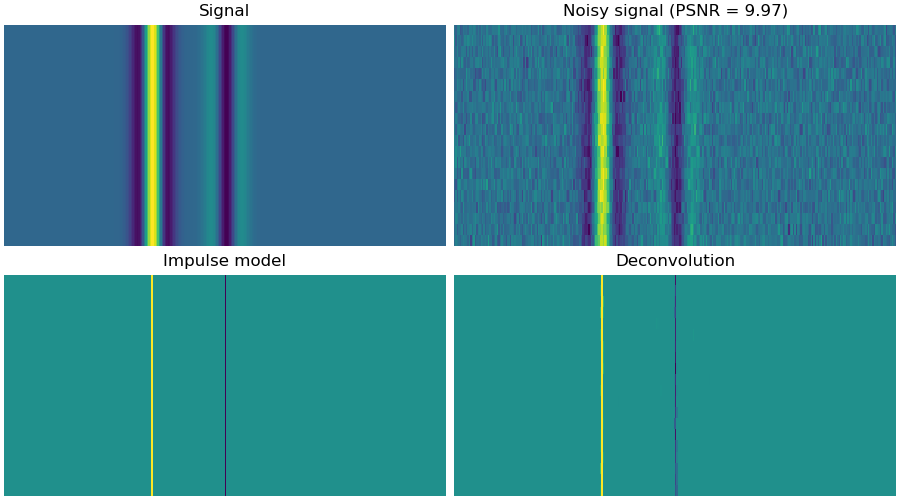

In [3]:
imshow_kwargs = {
    "aspect": "auto",
    "interpolation": "none",
}

RNG = np.random.default_rng(42)
Nch, Nt = 20, 300

model = np.zeros((Nch, Nt))
model[:, 100] = 1.0
model[:, 150] = -0.5

# impulse_response = np.real(sp.morlet(Nt, w=5.0))
impulse_response = sp.ricker(Nt, a=6.0)
impulse_response /= impulse_response.max()

signal = sp.convolve(model, impulse_response[None, :], mode="same")
noise = RNG.normal(size=signal.shape) * 1e-1
noisy_signal = signal + noise

PSNR = signal.max() / noise.std()

widths = np.linspace(2, 10, 1000)
a_opt = get_kernel_bandwidth(noisy_signal, widths)
print(a_opt)
kernel = sp.ricker(int(20 * a_opt), a_opt)
kernel /= kernel.max()

ISTA_solver = FISTA(lam=1e0, N=Nt, kernel=kernel, verbose=True)
loss, x, y_hat = ISTA_solver.solve(noisy_signal, N=200)

titles = ("Signal", f"Noisy signal (PSNR = {PSNR:.2f})", "Impulse model", "Deconvolution")

plt.close("all")
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 5), constrained_layout=True, sharex="all", sharey="all")
axes[0, 0].imshow(signal, **imshow_kwargs)
axes[0, 1].imshow(noisy_signal, **imshow_kwargs)
axes[1, 0].imshow(model / model.max(), vmin=-0.5, vmax=0.5, **imshow_kwargs)
axes[1, 1].imshow(x / (np.abs(x).max() + 1e-6), vmin=-0.5, vmax=0.5, **imshow_kwargs)
for ax, title in zip(axes.ravel(), titles):
    ax.axis("off")
    ax.set_title(title)